In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import torch
from tqdm import tqdm

from torch.optim import AdamW
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.tensorboard.writer import SummaryWriter

from sklearn.model_selection import train_test_split

from common import data
from common.training import training_loop, get_predictions

from algos import ts_ad

from common.models import resnet, deeplab
from common import metrics
from common.models.modutils import load_model


# Hyperparameters

In [3]:
log_dir = "./final/ts_ad_rmse"

input_len = 1024
output_len = 128

horizon = input_len + output_len
stride = 512

batch_size = 16

num_epochs = 10
learning_rate = 1e-3
weight_decay = 1e-2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


# Datasets

In [4]:
paths = data.get_dataset_paths("../data")
train, test = train_test_split(paths, test_size=0.1, random_state=42)


In [5]:
m_data_train = data.Marconi100Dataset(train, scaling=data.Scaling.STANDARD)
m_data_test = data.Marconi100Dataset(test, scaling=data.Scaling.STANDARD)


Loading: 100%|██████████| 25/25 [00:12<00:00,  1.93it/s]


In [6]:
train_loader = DataLoader(
    ts_ad.TSADEDataset(data.UnfoldedDataset(m_data_train, horizon=horizon, stride=stride), input_len),
    batch_size,
    shuffle=True,
)
test_loader = DataLoader(
    ts_ad.TSADEDataset(data.UnfoldedDataset(m_data_test, horizon=horizon, stride=output_len), input_len),
    batch_size,
    shuffle=False,
)


# Model

In [7]:
model = deeplab.DeepLabNet(
    resnet.ResNetFeatures(
        resnet.Bottleneck,
        resnet.RESNET50_LAYERS,
        return_layers=[resnet.LAYER_1, resnet.LAYER_4],
        replace_stride_with_dilation=[False, True, True],
        num_features=data.NUM_FEATURES,
    ),
    backbone_channels=[256, 2048],
    out_feats=data.NUM_FEATURES,
    out_shape=(output_len,)
).float()

optim = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
lr_sched = CosineAnnealingLR(optim, num_epochs)
engine = ts_ad.TSADEngine(
    model=model,
    device=device,
    optimizer=optim,
    lr_scheduler=lr_sched,
)


# Training

In [8]:
with SummaryWriter(log_dir + "/logs") as writer:
    training_loop(
        engine=engine,
        num_epochs=num_epochs,
        train_dataloader=train_loader,
        test_dataloader=test_loader,
        writer=writer,
        save_path=log_dir + "/models",
    )


Epoch 0 - train_loss=0.980 - test_loss=0.902 - cost=0.186 - threshold=2.035 - lr=1.00e-03


Epoch 1 - train_loss=0.923 - test_loss=0.900 - cost=0.186 - threshold=2.038 - lr=9.76e-04


Epoch 2 - train_loss=0.955 - test_loss=0.913 - cost=0.185 - threshold=2.037 - lr=9.05e-04


Epoch 3 - train_loss=0.874 - test_loss=0.920 - cost=0.185 - threshold=2.009 - lr=7.94e-04


Epoch 4 - train_loss=0.891 - test_loss=0.890 - cost=0.185 - threshold=1.971 - lr=6.55e-04


Epoch 5 - train_loss=0.889 - test_loss=0.892 - cost=0.185 - threshold=1.983 - lr=5.00e-04


Epoch 6 - train_loss=0.838 - test_loss=0.893 - cost=0.184 - threshold=1.973 - lr=3.45e-04


Epoch 7 - train_loss=0.880 - test_loss=0.882 - cost=0.185 - threshold=1.962 - lr=2.06e-04


Epoch 8 - train_loss=0.925 - test_loss=0.881 - cost=0.185 - threshold=1.967 - lr=9.55e-05


Epoch 9 - train_loss=0.895 - test_loss=0.880 - cost=0.185 - threshold=1.959 - lr=2.45e-05


# Evaluating

In [9]:
load_model(model, log_dir + "/models/model_9.pth", device);

In [10]:
# Cost model
cmodel = metrics.default_cmodel()


In [11]:
scores, labels = get_predictions(engine.predict, test_loader)


100%|██████████| 154/154 [00:32<00:00,  4.79it/s]


In [12]:
cmodel.fit(scores, labels).optimize()


(1.9594449727237224, 0.18489477)

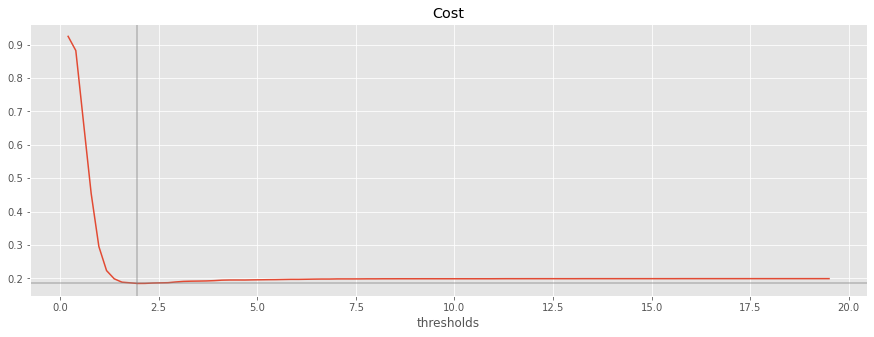

In [13]:
metrics.plot_cost(cmodel)


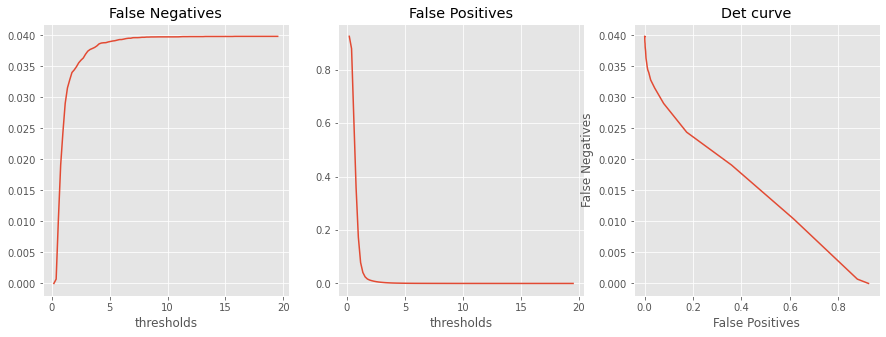

In [14]:
metrics.plot_errors_curve(
    cmodel.false_positives, cmodel.false_negatives, cmodel.thresholds, figsize=(15, 5)
)


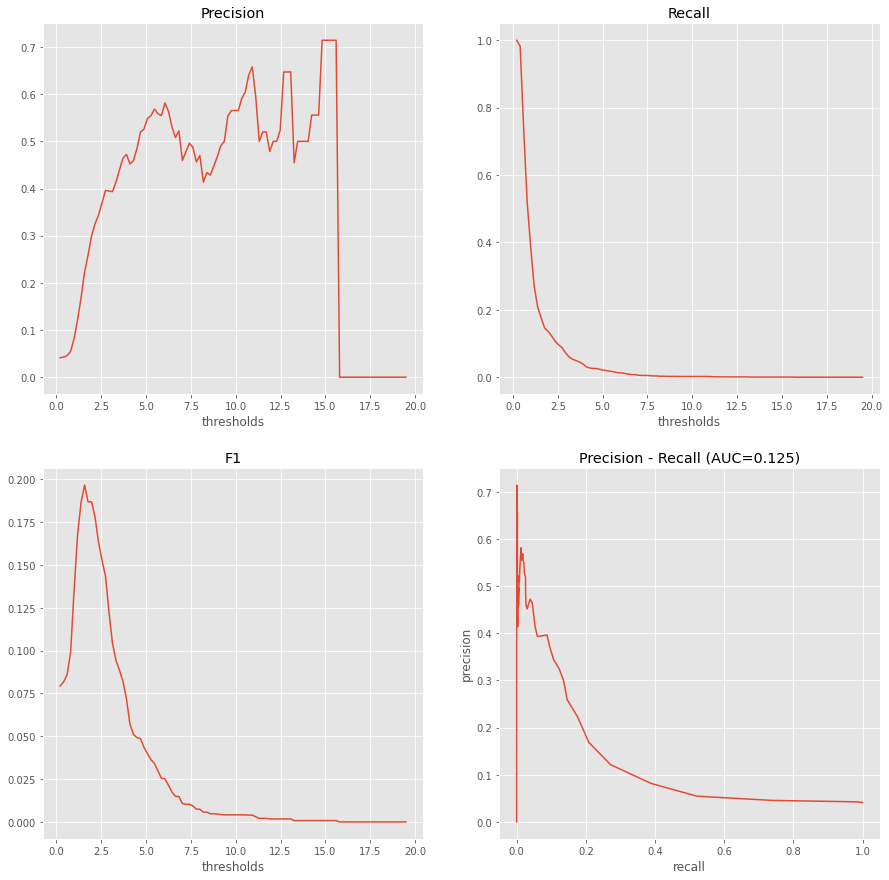

In [15]:
pr, rec, f1 = metrics.precision_recall_f1(
    cmodel.false_positives, cmodel.false_negatives
)
metrics.plot_precision_recall_f1_curve(pr, rec, f1, cmodel.thresholds)